# Load Raw Data

In [37]:
# Load dataset
import pandas as pd
df = pd.read_csv("dataset_processed.csv")
df = df[['Date','Arrangement', 'Room Type', 'Average Room Rate', 'Occupancy Rate', 'Is_Holiday', 'Is_Weekend', 'Is_Event', 'Is_SchoolHoliday', 'Is_Fasting']]
df['Arrangement'] = df['Arrangement'].str.replace('RBT', 'RB')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2182 non-null   object 
 1   Arrangement        2181 non-null   object 
 2   Room Type          2182 non-null   object 
 3   Average Room Rate  2182 non-null   float64
 4   Occupancy Rate     2182 non-null   float64
 5   Is_Holiday         2182 non-null   bool   
 6   Is_Weekend         2182 non-null   bool   
 7   Is_Event           2182 non-null   bool   
 8   Is_SchoolHoliday   2182 non-null   bool   
 9   Is_Fasting         2182 non-null   bool   
dtypes: bool(5), float64(2), object(3)
memory usage: 96.0+ KB


,Date,Arrangement,Room Type,Average Room Rate,Occupancy Rate,Is_Holiday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting
0,2024-01-01,NaN,Deluxe,5.000000e+05,0.633333,True,False,False,False,False
1,2024-01-01,RB,Deluxe,1.035475e+06,0.633333,True,False,False,False,False
2,2024-01-01,RO,Deluxe,5.672185e+05,0.633333,True,False,False,False,False
3,2024-01-01,RB,Executive Suite,2.136355e+06,0.633333,True,False,False,False,False
4,2024-01-02,RB,Deluxe,8.335923e+05,0.622222,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2177,2025-08-31,RB,Deluxe,8.043740e+05,0.347826,False,True,False,False,False
2178,2025-08-31,RO,Deluxe,7.313615e+05,0.347826,False,True,False,False,False
2179,2025-08-31,RB,Executive Suite,1.845325e+06,0.347826,False,True,False,False,False
2180,2025-09-01,RB,Deluxe,8.072872e+05,0.225806,False,False,False,False,False


# Occupancy Predictions

### Prepeare dataset for train

In [38]:
# enrich dataset
import numpy as np
from numpy.polynomial.legendre import legder
enrich = df.copy()
#Is_Holiday Is_Weekend Is_Event Is_SchoolHoliday are first, group by date, occupancy rate, we do not need Average Room Rate
enrich = enrich.groupby(['Date', 'Occupancy Rate', 'Is_Holiday', 'Is_Weekend', 'Is_Event', 'Is_SchoolHoliday', 'Is_Fasting']).agg({'Average Room Rate': 'mean'}).reset_index()
enrich = enrich.drop(columns=['Average Room Rate'])
enrich = enrich.rename(columns={'Is_Holiday': 'Is_NationalHoliday'})
enrich = enrich.sort_values('Date').reset_index(drop=True)

seed_hol = (enrich['Is_NationalHoliday'].astype(bool) | enrich['Is_Weekend'].astype(bool)).to_numpy()
n = len(seed_hol)

left_seed  = np.r_[False, seed_hol[:-1]]
right_seed = np.r_[seed_hol[1:], False]
is_bridge = (~seed_hol) & left_seed & right_seed
enrich['Is_Bridge'] = is_bridge

is_nat   = enrich['Is_NationalHoliday'].to_numpy(dtype=bool)
is_we    = enrich['Is_Weekend'].to_numpy(dtype=bool)
is_br    = enrich['Is_Bridge'].to_numpy(dtype=bool)

base = is_nat | is_br

left_base = np.r_[False, base[:-1]]
right_base = np.r_[base[1:], False]
wk1 = is_we & (left_base | right_base) 

left_wk1 = np.r_[False, wk1[:-1]]
right_wk1 = np.r_[wk1[1:], False]
wk2 = is_we & (left_wk1 | right_wk1)

is_holiday_final = base | wk1 | wk2
enrich['Is_Holiday'] = is_holiday_final

block_id = (~is_holiday_final).cumsum() 
enrich['Holiday_Duration'] = 0
enrich['Days_of_Holiday'] = 0

mask = is_holiday_final
grp = pd.Series(block_id[mask]).groupby(block_id[mask])
sizes = grp.transform('size').to_numpy()

order_in_block = grp.cumcount() + 1

enrich.loc[mask, 'Holiday_Duration'] = sizes
enrich.loc[mask, 'Days_of_Holiday']  = order_in_block.to_numpy()

# Ambil array boolean hari libur (sudah termasuk bridge, sesuai definisi Anda)
is_hol = enrich["Is_Holiday"].to_numpy(dtype=bool)
n = len(enrich)
INF = 10**9

# Sweep ke depan (jarak dari libur terakhir)
dist_fwd = np.full(n, INF, dtype=int)
last = -INF
for i in range(n):
    if is_hol[i]:
        last = i
    dist_fwd[i] = i - last

# Sweep ke belakang (jarak ke libur berikutnya)
dist_bwd = np.full(n, INF, dtype=int)
last = INF
for i in range(n - 1, -1, -1):
    if is_hol[i]:
        last = i
    dist_bwd[i] = last - i

# Ambil jarak minimum; hari libur = 0
dist = np.minimum(dist_fwd, dist_bwd)
dist[is_hol] = 0
enrich["Distance_to_Holiday"] = dist

enrich['Day_of_Week']  = pd.to_datetime(enrich['Date']).dt.dayofweek
enrich['Day_of_Month'] = pd.to_datetime(enrich['Date']).dt.day
enrich['Month']        = pd.to_datetime(enrich['Date']).dt.month
enrich['Year']         = pd.to_datetime(enrich['Date']).dt.year

enrich

,Date,Occupancy Rate,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year
0,2024-01-01,0.633333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024
1,2024-01-02,0.622222,False,False,False,False,False,False,False,0,0,1,1,2,1,2024
2,2024-01-03,0.678161,False,False,False,False,False,False,False,0,0,2,2,3,1,2024
3,2024-01-04,0.651685,False,False,False,False,False,False,False,0,0,3,3,4,1,2024
4,2024-01-05,0.703297,False,False,False,False,False,False,False,0,0,4,4,5,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2025-08-28,0.806452,False,False,True,False,False,False,False,0,0,10,3,28,8,2025
606,2025-08-29,0.793478,False,False,False,False,False,False,False,0,0,11,4,29,8,2025
607,2025-08-30,0.571429,False,True,False,False,False,False,False,0,0,12,5,30,8,2025
608,2025-08-31,0.347826,False,True,False,False,False,False,False,0,0,13,6,31,8,2025


### Train for Occupancy Predictions

R² test: 0.4527108882345655
Test R²=0.453 | MAE=0.110 | RMSE=0.133 | MAPE=20.744%


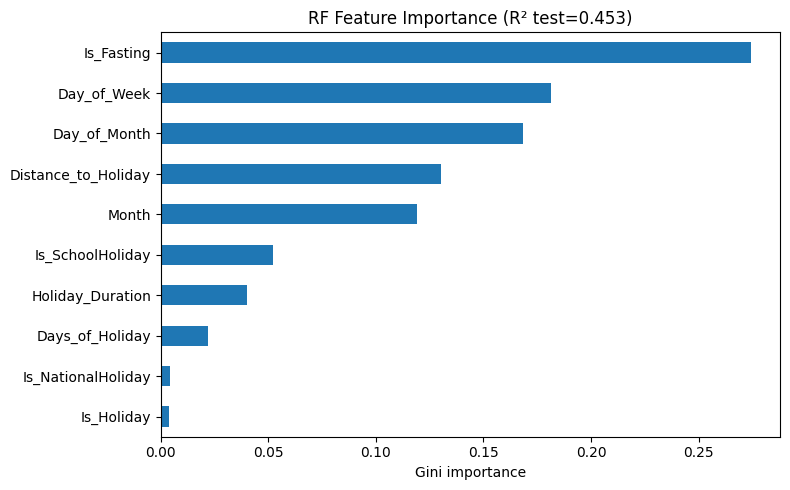

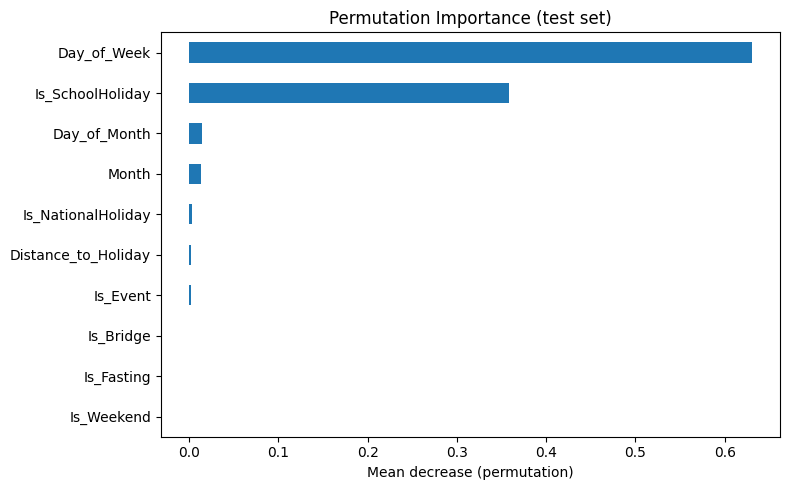

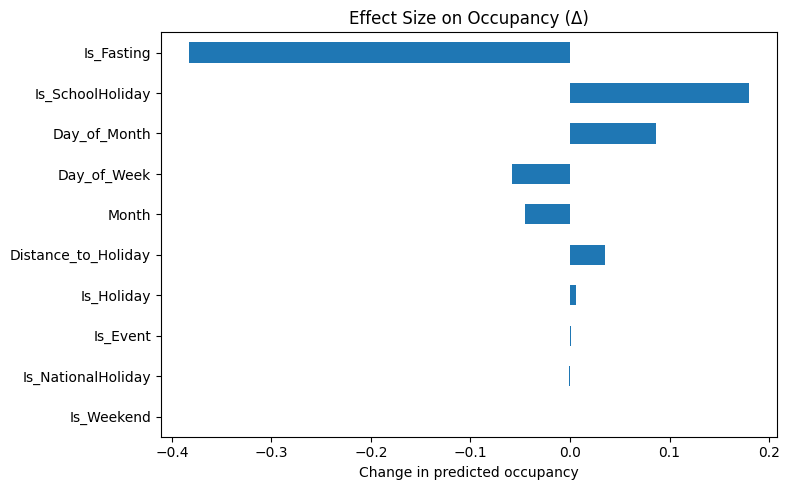

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


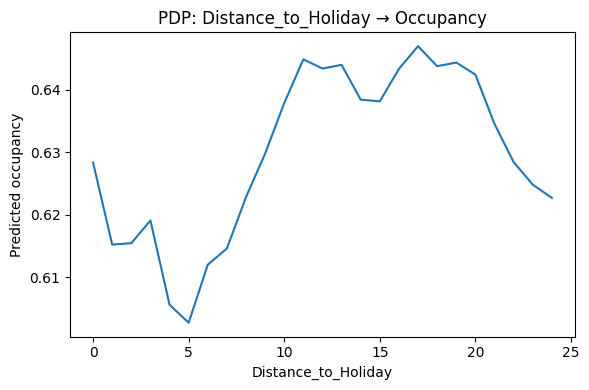

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 7 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


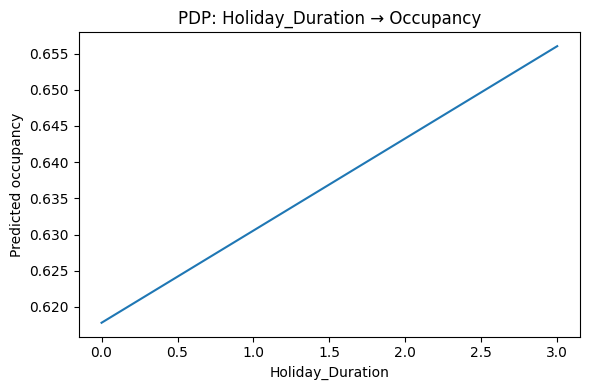

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


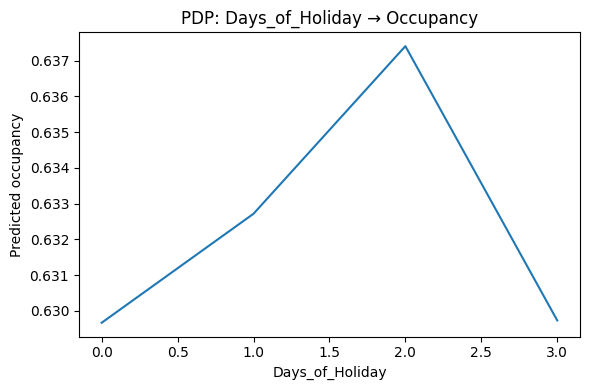

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


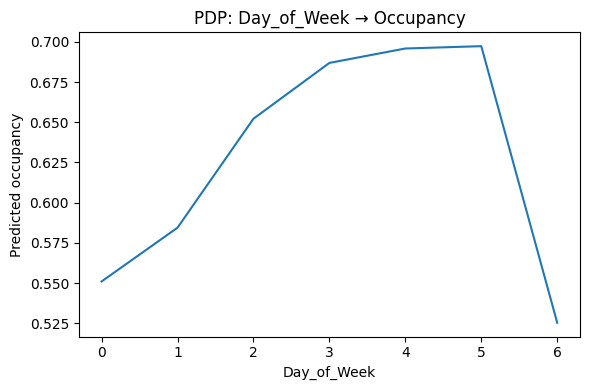

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 11 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


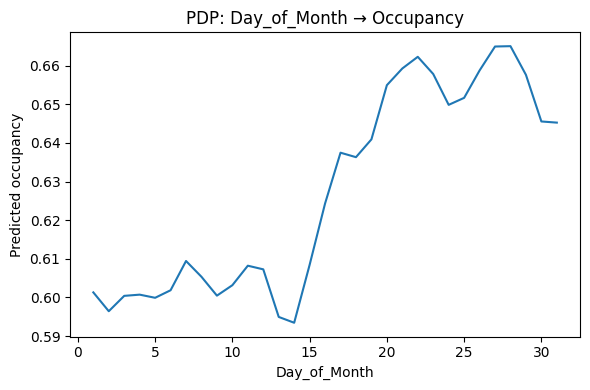

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
# Make a RF (split train & test) to see how independent affecting Occupancy Rate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import X_DTYPE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rfset = enrich.sort_values('Date').copy()

target = 'Occupancy Rate'
drop_cols = ["Date", "Year", target]

# Split train and test (train 2024 - Juni 2025, test Juli 2025 - Agustus 2025)
train = enrich[enrich['Date'] < '2025-07-01'].copy()
test = enrich[enrich['Date'] >= '2025-07-01'].copy()

features = [c for c in rfset.columns if c not in drop_cols]

X_tr, y_tr = train[features].copy(), train[target].astype(float).clip(1e-6, 1-1e-6)
X_te,  y_te  = test[features].copy(),  test[target].astype(float).clip(1e-6, 1-1e-6)

def clean_bool(df):
    for c in df.columns:
        if df[c].dtype == bool:
            df[c] = df[c].astype(int)
        elif df[c].dtype == object:
            uniq = set(pd.unique(df[c].dropna()))
            if uniq <= {"True","False"}:
                df[c] = df[c].map({"False":0, "True":1}).astype("Int64").fillna(0).astype(int)
    return df

X_tr = clean_bool(X_tr)
X_te  = clean_bool(X_te)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=0,
    min_samples_leaf=2, 
    n_jobs=-1
    )
rf.fit(X_tr, y_tr)

r2_test = r2_score(y_te, rf.predict(X_te))
print("R² test:", r2_test)

y_pred = rf.predict(X_te)

r2  = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mape= (np.abs((y_te - y_pred) / np.maximum(y_te, 1e-6))).mean()

print(f"Test R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f} | MAPE={mape:.3%}")

fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
perm = permutation_importance(rf, X_te, y_te, n_repeats=8, random_state=0, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)

def barplot(series, title, xlabel):
    top = series.head(10)
    plt.figure(figsize=(8,5))
    top[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

barplot(fi, f"RF Feature Importance (R² test={r2_score(y_te, rf.predict(X_te)):.3f})", "Gini importance")
barplot(pi, "Permutation Importance (test set)", "Mean decrease (permutation)")

def binary_effect(model, Xtest, col):
    X0 = Xtest.copy(); X0[col] = 0
    X1 = Xtest.copy(); X1[col] = 1
    return float(model.predict(X1).mean() - model.predict(X0).mean())

# gunakan X_te, bukan X
binary_cols = [c for c in X_te.columns if set(pd.unique(X_te[c])).issubset({0,1})]
bin_eff = {c: binary_effect(rf, X_te, c) for c in binary_cols}

def numeric_effect_quantile(model, Xtest, col, q_low=0.10, q_high=0.90):
    Xlo, Xhi = Xtest.copy(), Xtest.copy()
    lo, hi = np.percentile(Xtest[col], q_low*100), np.percentile(Xtest[col], q_high*100)
    if lo == hi:     # kalau varians kolom sangat kecil / konstan di test
        return 0.0
    Xlo[col] = lo
    Xhi[col] = hi
    return float(model.predict(Xhi).mean() - model.predict(Xlo).mean())

num_cols = [c for c in X_te.columns if c not in binary_cols]
num_eff  = {c: numeric_effect_quantile(rf, X_te, c) for c in num_cols}

effect = pd.Series({**bin_eff, **num_eff}).sort_values(key=lambda s: s.abs(), ascending=False)
barplot(effect, "Effect Size on Occupancy (Δ)", "Change in predicted occupancy")

# PDP: cek keberadaan kolom di X_te
def pdp1d_plot(model, Xref, col):
    idx = list(Xref.columns).index(col)
    pdp = partial_dependence(model, Xref, [idx], kind="average")
    xs = pdp.get("grid_values", pdp.get("values"))[0]
    ys = pdp["average"][0]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys)
    plt.title(f"PDP: {col} → Occupancy")
    plt.xlabel(col); plt.ylabel("Predicted occupancy")
    plt.tight_layout(); plt.show()

for col in ["Distance_to_Holiday","Holiday_Duration","Days_of_Holiday","Day_of_Week","Day_of_Month"]:
    if col in X_te.columns:
        pdp1d_plot(rf, X_te, col)

X_full, y_full = rfset[features].copy(), rfset[target].astype(float).clip(1e-6, 1-1e-6)
X_full = clean_bool(X_full)
rf.fit(X_full, y_full)

### Prepare Dataset for Predictions

In [40]:
# Build Calendar

# Load holidays
holidays = pd.read_csv("holidays_info.csv")
holidays["Date"] = pd.to_datetime(holidays["Date"])

# events = holidays[holidays["Kind"] == "event"]

# find latest date in enrich than add one day to it
latest_date = pd.to_datetime(enrich['Date'].max()) + pd.Timedelta(days=1)

end_2026 = pd.Timestamp("2026-12-31")

future_cal = pd.date_range(start=latest_date, end=end_2026)

future_rows = []
for date in future_cal:
    # Check if date is holiday
    is_national_holiday = False
    is_weekend = date.weekday() >= 5
    is_school_holiday = False  # Will be determined from holidays_2026
    is_event = False  # Will be determined from holidays_2026
    is_fasting = False

    holidays_info = holidays[holidays["Date"] == date]
    if not holidays_info.empty:
        is_national_holiday = holidays_info.iloc[0]["Kind"] in ["national", "joint"]
        is_school_holiday = holidays_info.iloc[0]["Kind"] == "school"
        is_event = holidays_info.iloc[0]["Kind"] == "event"
        is_fasting = holidays_info.iloc[0]["Kind"] == "fasting"

    future_rows.append({
        "Date": date,
        "Is_NationalHoliday": is_national_holiday,
        "Is_Weekend": is_weekend,
        "Is_Event": is_event,
        "Is_SchoolHoliday": is_school_holiday,     
        "Is_Fasting": is_fasting,
    })

future = pd.DataFrame(future_rows)


seed_hol = (future['Is_NationalHoliday'].astype(bool) | future['Is_Weekend'].astype(bool)).to_numpy()
n = len(seed_hol)

left_seed  = np.r_[False, seed_hol[:-1]]
right_seed = np.r_[seed_hol[1:], False]
is_bridge = (~seed_hol) & left_seed & right_seed
future['Is_Bridge'] = is_bridge

is_nat   = future['Is_NationalHoliday'].to_numpy(dtype=bool)
is_we    = future['Is_Weekend'].to_numpy(dtype=bool)
is_br    = future['Is_Bridge'].to_numpy(dtype=bool)

base = is_nat | is_br

left_base  = np.r_[False, base[:-1]]
right_base = np.r_[base[1:], False]
wk1 = is_we & (left_base | right_base)

left_wk1  = np.r_[False, wk1[:-1]]
right_wk1 = np.r_[wk1[1:], False]
wk2 = is_we & (left_wk1 | right_wk1)

is_holiday_final = base | wk1 | wk2
future['Is_Holiday'] = is_holiday_final

block_id = (~is_holiday_final).cumsum() 
future['Holiday_Duration'] = 0
future['Days_of_Holiday'] = 0

mask = is_holiday_final
grp = pd.Series(block_id[mask]).groupby(block_id[mask])
sizes = grp.transform('size').to_numpy()

order_in_block = grp.cumcount() + 1

future.loc[mask, 'Holiday_Duration'] = sizes
future.loc[mask, 'Days_of_Holiday']  = order_in_block.to_numpy()

# Ambil array boolean hari libur (sudah termasuk bridge, sesuai definisi Anda)
is_hol = future["Is_Holiday"].to_numpy(dtype=bool)
n = len(future)
INF = 10**9

# Sweep ke depan (jarak dari libur terakhir)
dist_fwd = np.full(n, INF, dtype=int)
last = -INF
for i in range(n):
    if is_hol[i]:
        last = i
    dist_fwd[i] = i - last

# Sweep ke belakang (jarak ke libur berikutnya)
dist_bwd = np.full(n, INF, dtype=int)
last = INF
for i in range(n - 1, -1, -1):
    if is_hol[i]:
        last = i
    dist_bwd[i] = last - i

# Ambil jarak minimum; hari libur = 0
dist = np.minimum(dist_fwd, dist_bwd)
dist[is_hol] = 0
future["Distance_to_Holiday"] = dist

future['Day_of_Week']  = pd.to_datetime(future['Date']).dt.dayofweek
future['Day_of_Month'] = pd.to_datetime(future['Date']).dt.day
future['Month']        = pd.to_datetime(future['Date']).dt.month
future['Year']         = pd.to_datetime(future['Date']).dt.year


future


,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year
0,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025
1,2025-09-03,False,False,False,False,False,False,False,0,0,2,2,3,9,2025
2,2025-09-04,False,False,False,False,False,False,False,0,0,1,3,4,9,2025
3,2025-09-05,True,False,False,False,False,False,True,3,1,0,4,5,9,2025
4,2025-09-06,False,True,False,False,False,False,True,3,2,0,5,6,9,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2026-12-27,False,True,False,True,False,False,True,4,4,0,6,27,12,2026
482,2026-12-28,False,False,False,True,False,False,False,0,0,1,0,28,12,2026
483,2026-12-29,False,False,False,True,False,False,False,0,0,2,1,29,12,2026
484,2026-12-30,False,False,False,True,False,False,False,0,0,3,2,30,12,2026


### Predictions

In [41]:
# Make a prediction
features = [
    "Is_NationalHoliday","Is_Weekend","Is_Event", "Is_SchoolHoliday", "Is_Fasting",
    "Is_Bridge","Is_Holiday",
    "Holiday_Duration","Days_of_Holiday","Distance_to_Holiday",
    "Day_of_Week","Day_of_Month","Month"
]

X_future = future[features].copy()

# pastikan boolean → int
for c in X_future.columns:
    if X_future[c].dtype == bool:
        X_future[c] = X_future[c].astype(int)
    if X_future[c].dtype == object and set(pd.unique(X[c])) <= {"True","False"}:
        X_future[c] = X_future[c].map({"False":0, "True":1}).astype(int)

future["Predicted_Occupancy"] = rf.predict(X_future)
future

,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,Predicted_Occupancy
0,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563
1,2025-09-03,False,False,False,False,False,False,False,0,0,2,2,3,9,2025,0.511151
2,2025-09-04,False,False,False,False,False,False,False,0,0,1,3,4,9,2025,0.503816
3,2025-09-05,True,False,False,False,False,False,True,3,1,0,4,5,9,2025,0.616292
4,2025-09-06,False,True,False,False,False,False,True,3,2,0,5,6,9,2025,0.691866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2026-12-27,False,True,False,True,False,False,True,4,4,0,6,27,12,2026,0.717535
482,2026-12-28,False,False,False,True,False,False,False,0,0,1,0,28,12,2026,0.743753
483,2026-12-29,False,False,False,True,False,False,False,0,0,2,1,29,12,2026,0.801962
484,2026-12-30,False,False,False,True,False,False,False,0,0,3,2,30,12,2026,0.860269


# Analyze Occ-ARR

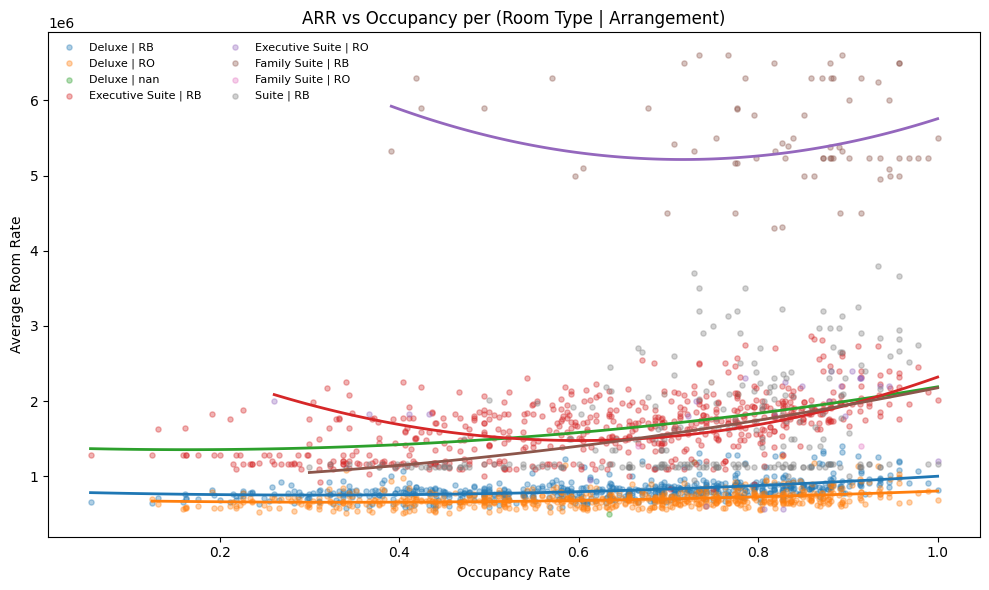

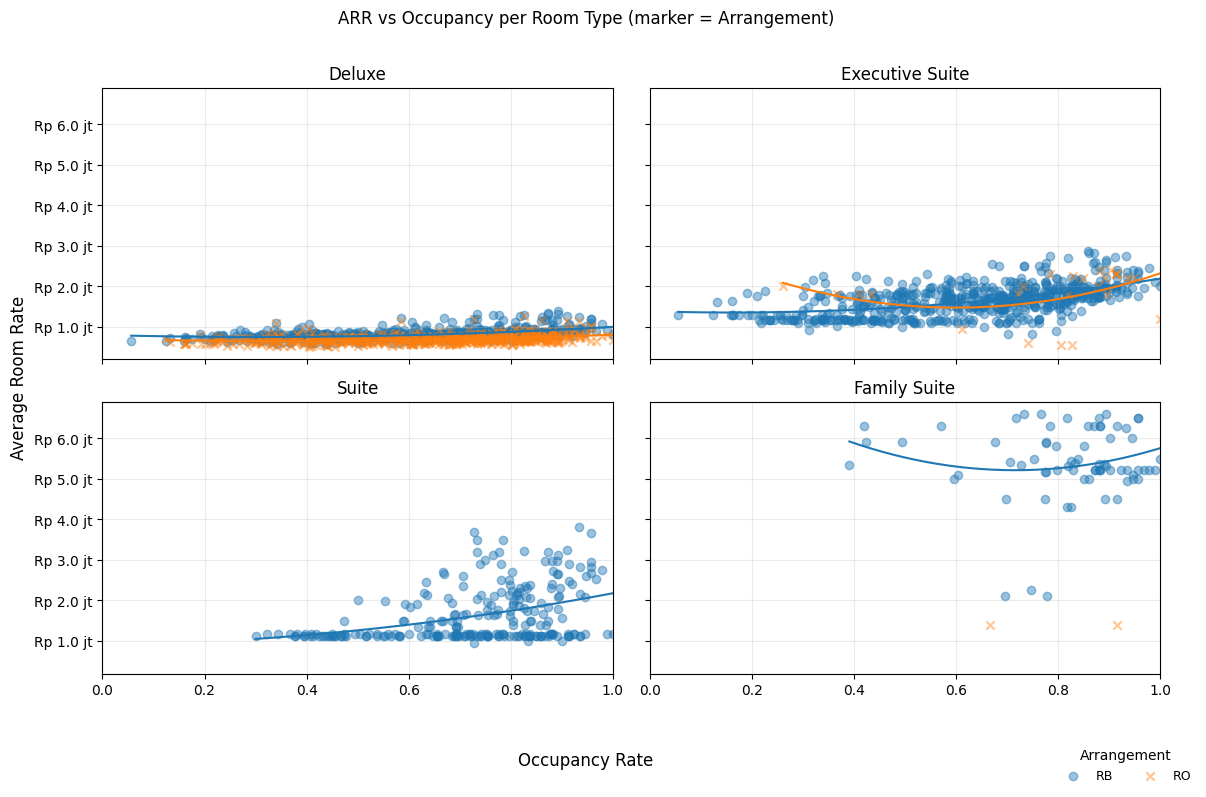

In [42]:
# Analisis Occ-ARR
priceanalysis = df.copy()
priceanalysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

In [43]:
rt='Family Suite'
# Deluxe, Executive Suite, Suite, Family Suite

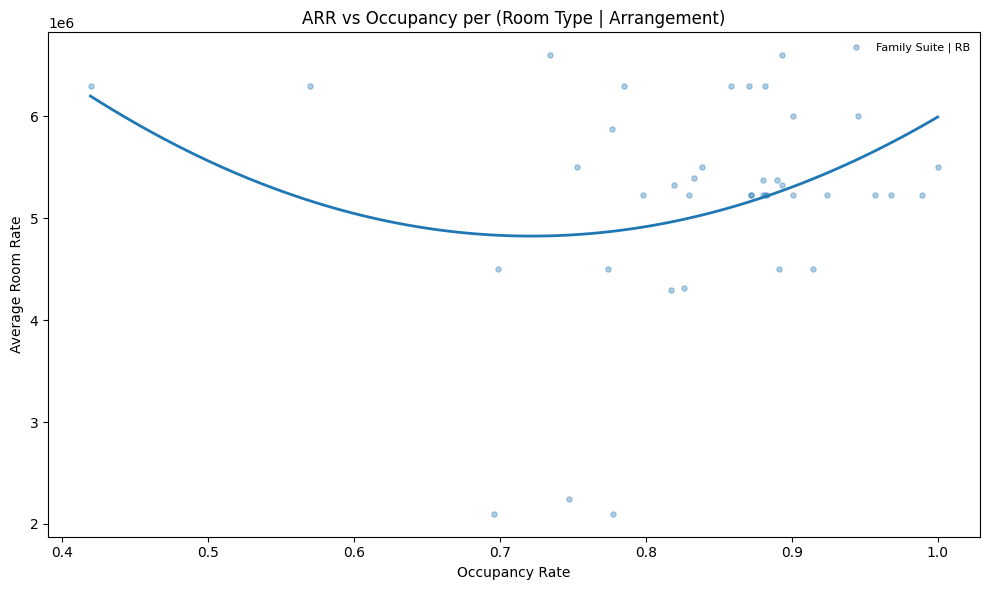

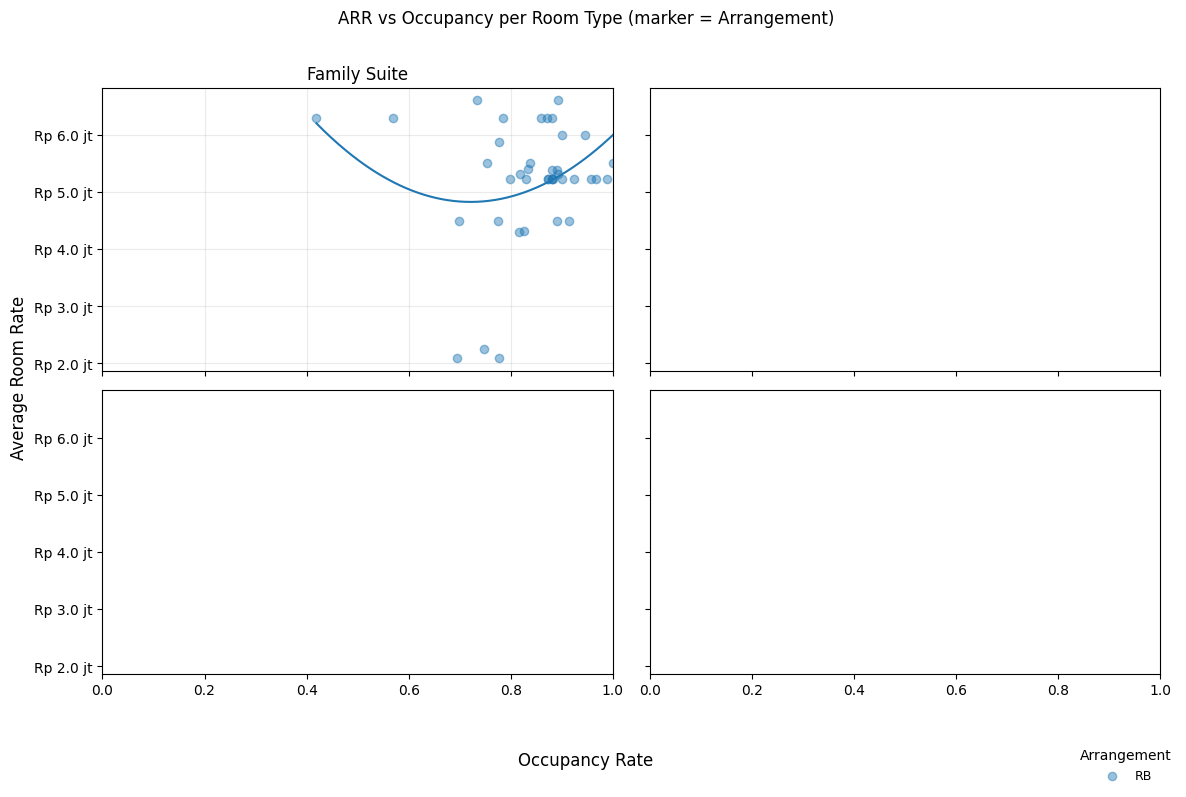

In [44]:
# Analisis Occ-ARR (2024)
priceanalysis = df.copy()
priceanalysis = priceanalysis[priceanalysis['Date'] < '2025-01-01']
priceanalysis = priceanalysis[priceanalysis['Room Type'] == rt]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

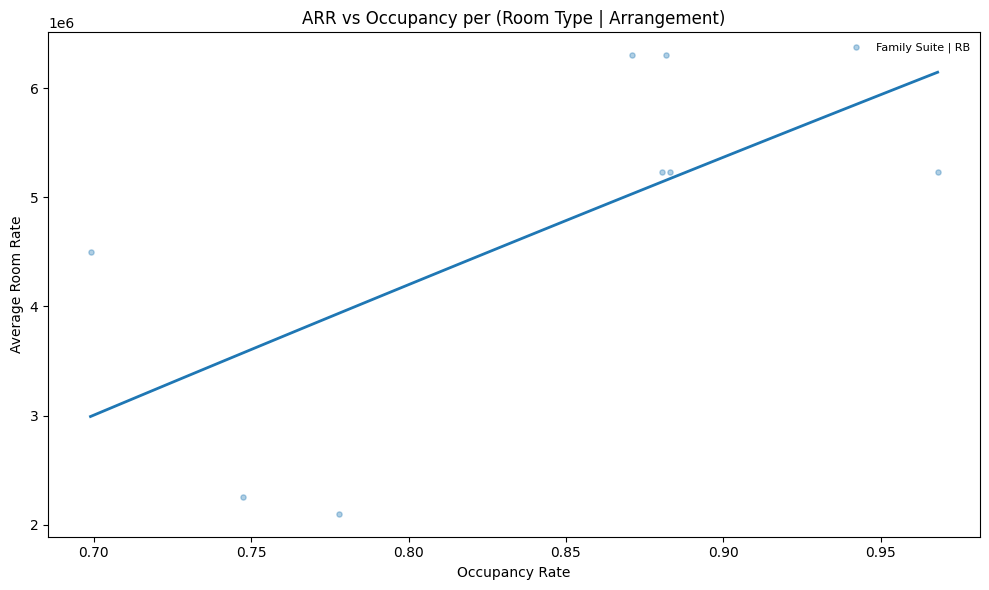

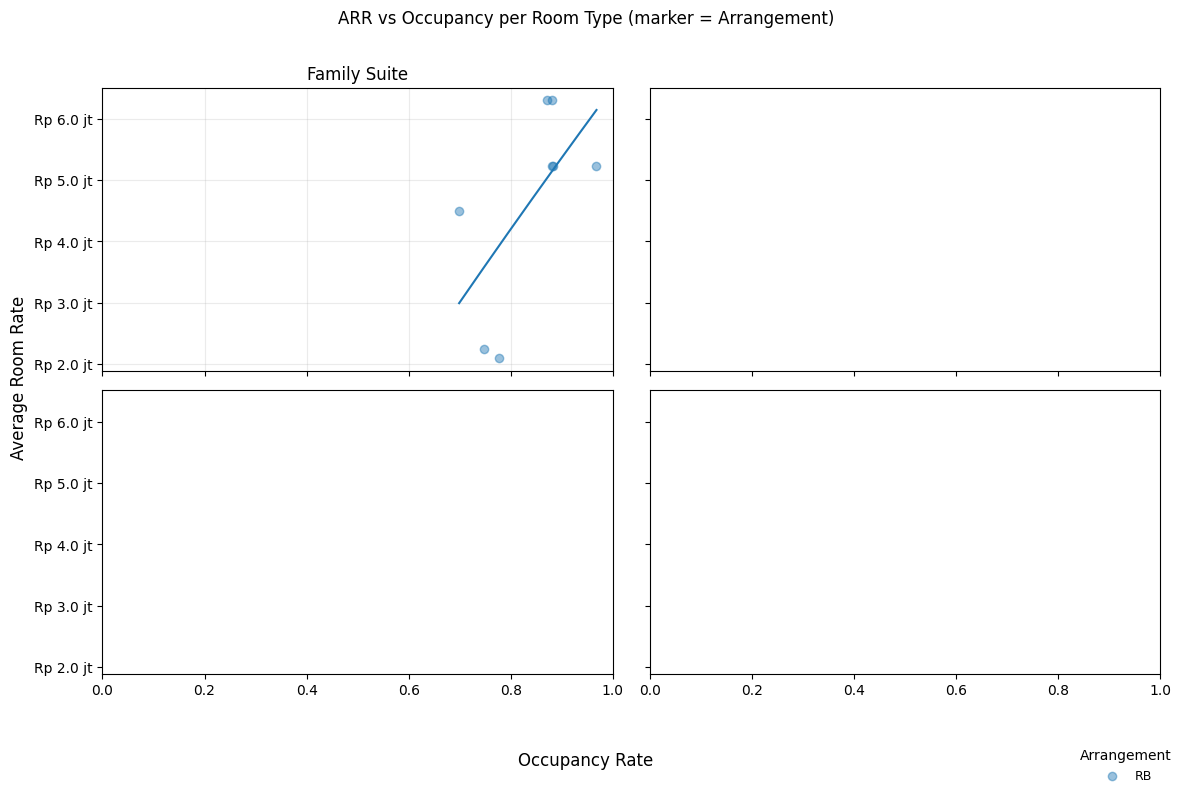

In [45]:
# Analisis Occ-ARR (2024 remove outliers - Deluxe)
priceanalysis = df.copy()
priceanalysis = priceanalysis[priceanalysis['Date'] < '2025-01-01']
priceanalysis = priceanalysis[priceanalysis['Room Type'] == rt]

priceanalysis = priceanalysis[
        (~priceanalysis['Is_Holiday']) &
        (~priceanalysis['Is_Weekend']) &
        (~priceanalysis['Is_Event']) &
        (~priceanalysis['Is_SchoolHoliday'])
    ]
    
# Remove outliers using IQR method
Q1 = priceanalysis["Average Room Rate"].quantile(0.25)
Q3 = priceanalysis["Average Room Rate"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

priceanalysis = priceanalysis[
    (priceanalysis["Average Room Rate"] >= lower_bound) & 
    (priceanalysis["Average Room Rate"] <= upper_bound)
]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

priceanalysis['Occupancy Rate'] = priceanalysis['Occupancy Rate'].astype(float).clip(1e-6, 1-1e-6)
priceanalysis['Average Room Rate'] = priceanalysis['Average Room Rate'].astype(float)

priceanalysis["RT_ARR"] = priceanalysis["Room Type"].astype(str) + " | " + priceanalysis["Arrangement"].astype(str)
# scatter + poly deg=2 per kombinasi
plt.figure(figsize=(10,6))

# warna otomatis per kombinasi
for (key, g) in priceanalysis.groupby("RT_ARR"):
    x = g["Occupancy Rate"].values
    y = g["Average Room Rate"].values
    # scatter
    plt.scatter(x, y, s=14, alpha=0.35, label=key)
    # fit polinomial derajat-2 (jika titik cukup)
    if len(g) >= 6:
        try:
            coefs = np.polyfit(x, y, deg=2)   # y ≈ a*x^2 + b*x + c
            xx = np.linspace(x.min(), x.max(), 120)
            yy = np.polyval(coefs, xx)
            plt.plot(xx, yy, linewidth=2)
        except np.linalg.LinAlgError:
            pass

plt.title("ARR vs Occupancy per (Room Type | Arrangement)")
plt.xlabel("Occupancy Rate")
plt.ylabel("Average Room Rate")
plt.legend(ncols=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

markers = {"RB": "o", "RO": "x"}
alpha_pts = 0.45
deg_fit   = 2

# room type yang akan diplot (maks 4 untuk grid 2x2)
roomtypes_all = priceanalysis["Room Type"].unique().tolist()
roomtypes = roomtypes_all[:4]

# siapkan batas y global (konsisten di semua subplot)
mask = priceanalysis["Room Type"].isin(roomtypes)
y_all = priceanalysis.loc[mask, "Average Room Rate"].to_numpy()
ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin_glob, ymax_glob = ymin - pad, ymax + pad

# formatter: tampilkan Rp … jt (juta)
def rupiah_juta(x, pos):
    return f"Rp {x/1_000_000:.1f} jt"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, rt in zip(axes, roomtypes):
    sub = priceanalysis[priceanalysis["Room Type"] == rt].copy()

    # scatter per arrangement + garis fit per arrangement
    for arr, mk in markers.items():
        g = sub[sub["Arrangement"] == arr]
        if g.empty:
            continue

        ax.scatter(g["Occupancy Rate"], g["Average Room Rate"],
                   marker=mk, alpha=alpha_pts, label=arr)

        # garis tren (poly deg=2) hanya jika data cukup
        if len(g) >= 8:
            x = g["Occupancy Rate"].to_numpy()
            y = g["Average Room Rate"].to_numpy()
            xs = np.linspace(x.min(), x.max(), 200)
            p  = np.poly1d(np.polyfit(x, y, deg_fit))
            ax.plot(xs, p(xs))

    ax.set_title(f"{rt}")
    ax.grid(True, alpha=0.25)
    ax.set_ylim(ymin_glob, ymax_glob)
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_juta))
    ax.set_xlim(0, 1)  # occupancy 0–1

# label sumbu bersama
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)
fig.supxlabel("Occupancy Rate")
fig.supylabel("Average Room Rate")

# legenda gabungan (arrangement)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title="Arrangement",
           loc="lower center", bbox_to_anchor=(0.95, -0.02),
           ncols=len(labels), frameon=False, fontsize=9, title_fontsize=10)

# turunkan sedikit suptitle agar tidak tertimpa
fig.suptitle("ARR vs Occupancy per Room Type (marker = Arrangement)", y=0.96)

plt.tight_layout(rect=[0,0.04,1,0.95])
plt.show()

# ARR Predictions

### Prepare Dataset for train

In [46]:
# prepare dataset for train
arrtrain = df.copy()
# Drop Occupancy Rate, Is_Holiday, Is_Weekend, Is_Event, Is_SchoolHoliday
arrtrain = arrtrain.drop(columns=['Occupancy Rate', 'Is_Holiday', 'Is_Weekend', 'Is_Event', 'Is_SchoolHoliday', 'Is_Fasting'])
# merge arrtrain with enrich
arrtrain = pd.merge(arrtrain, enrich, on='Date', how='left')
arrtrain

,Date,Arrangement,Room Type,Average Room Rate,Occupancy Rate,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year
0,2024-01-01,NaN,Deluxe,5.000000e+05,0.633333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024
1,2024-01-01,RB,Deluxe,1.035475e+06,0.633333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024
2,2024-01-01,RO,Deluxe,5.672185e+05,0.633333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024
3,2024-01-01,RB,Executive Suite,2.136355e+06,0.633333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024
4,2024-01-02,RB,Deluxe,8.335923e+05,0.622222,False,False,False,False,False,False,False,0,0,1,1,2,1,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2025-08-31,RB,Deluxe,8.043740e+05,0.347826,False,True,False,False,False,False,False,0,0,13,6,31,8,2025
2178,2025-08-31,RO,Deluxe,7.313615e+05,0.347826,False,True,False,False,False,False,False,0,0,13,6,31,8,2025
2179,2025-08-31,RB,Executive Suite,1.845325e+06,0.347826,False,True,False,False,False,False,False,0,0,13,6,31,8,2025
2180,2025-09-01,RB,Deluxe,8.072872e+05,0.225806,False,False,False,False,False,False,False,0,0,14,0,1,9,2025


### Train

R2 Score (test): 0.8298
Test R²=nan, MAE=3947553.244, RMSE=3948926.209, MAPE=281.968%


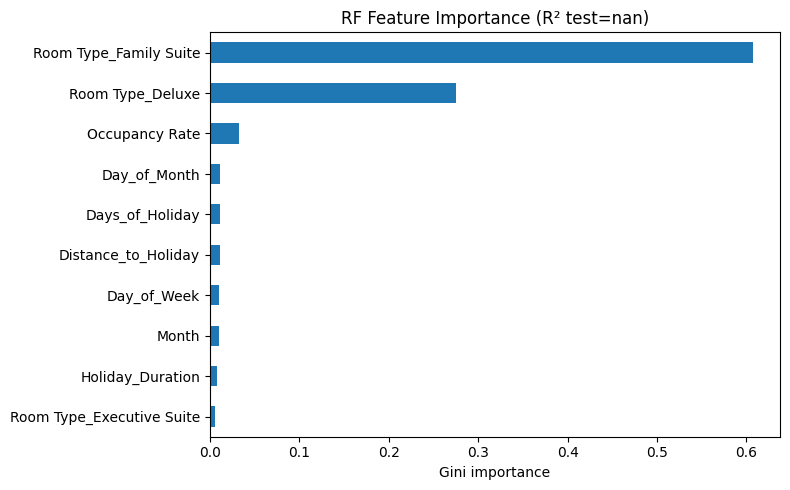

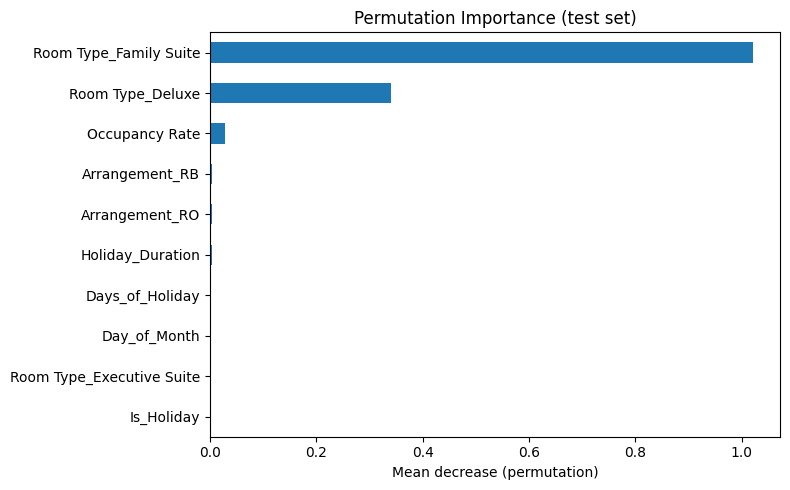

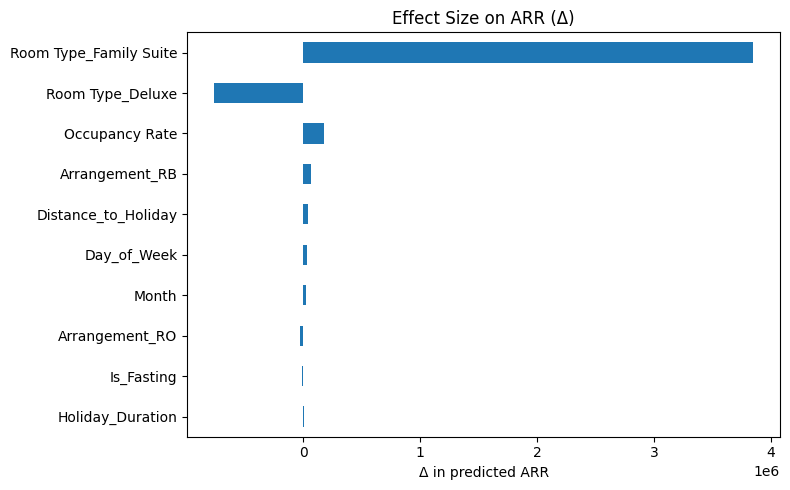

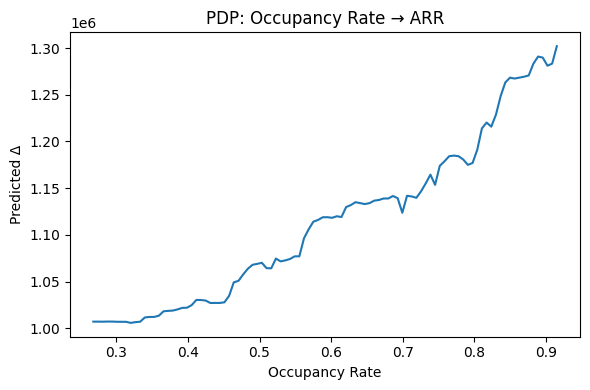

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


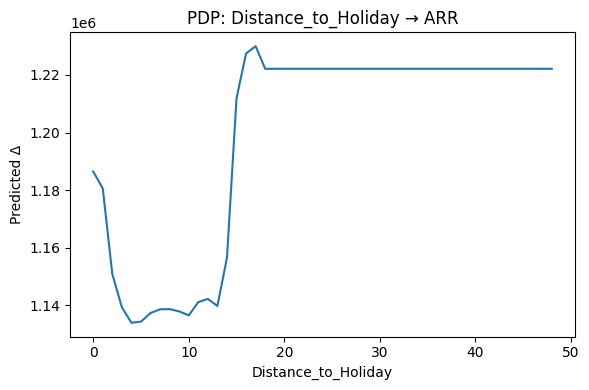

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


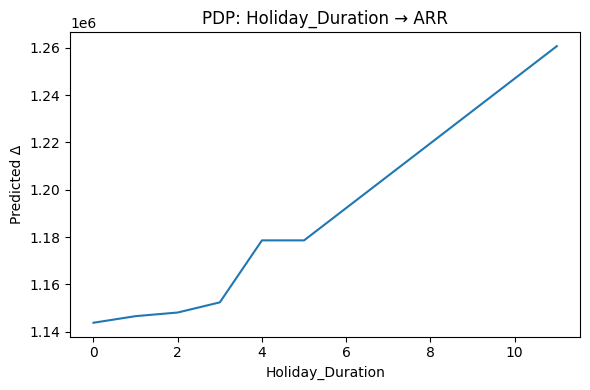

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


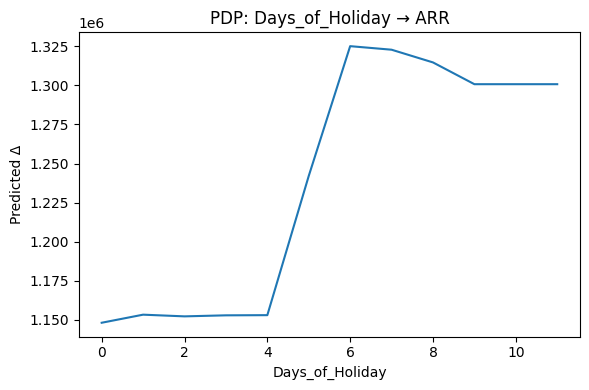

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 11 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


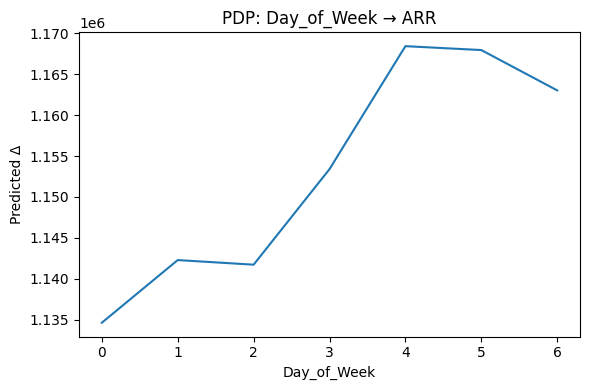

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 12 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


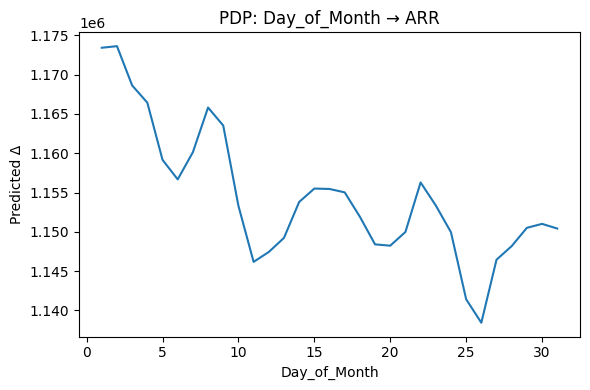

,Room Type,Arrangement,n_samples,MAE,RMSE,MAPE,R2
6,Family Suite,RO,2,3947553.24,3948926.21,2.82,NaN
1,Executive Suite,RO,14,703159.33,730085.75,0.34,-3.07
0,Suite,RB,191,523849.54,690393.46,0.32,-0.00
4,Executive Suite,RB,427,283060.97,354013.19,0.16,0.11
5,Family Suite,RB,56,732249.16,1011690.22,0.16,-0.23
3,Deluxe,RB,428,98144.78,127512.55,0.11,-0.11
2,Deluxe,RO,427,80719.03,115054.59,0.10,-0.33


In [47]:
# Make a RF (split train & test) to see how independent affecting Average Room Rate

trainset = arrtrain.sort_values('Date').copy()

target = 'Average Room Rate'
drop_cols = ["Date", "Year", target]

train = trainset[trainset['Date'] < '2024-07-01'].copy()
test = trainset[trainset['Date'] >= '2024-07-01'].copy()

features = [c for c in train.columns if c not in drop_cols]

def clean_bool(df):
    for c in df.columns:
        if df[c].dtype == bool:
            df[c] = df[c].astype(int)
        if df[c].dtype == object and set(pd.unique(df[c])) <= {"True","False"}:
            df[c] = df[c].map({"False":0, "True":1}).astype(int)
    return df

X_train = clean_bool(train)
X_test = clean_bool(test)

cat_cols = []
for c in ["Room Type", "Arrangement"]:
    if c in features and train[c].dtype == object:
        cat_cols.append(c)

X_train_raw = train[features].copy()
X_test_raw  = test[features].copy()


X_train = pd.get_dummies(X_train_raw, columns=cat_cols, drop_first=False)
X_test  = pd.get_dummies(X_test_raw,  columns=cat_cols, drop_first=False)
model_cols = X_train.columns.tolist() 

# Samakan kolom train/test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train[target].astype(float)
y_test  = test[target].astype(float)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=0,
    min_samples_leaf=2,
    n_jobs=-1
    )
rf.fit(X_train, y_train)

r2_test = r2_score(y_test, rf.predict(X_test))
print(f"R2 Score (test): {r2_test:.4f}")

y_pred = rf.predict(X_test)

eval_df = test.copy()
eval_df["y_true"] = y_test
eval_df["y_pred"] = y_pred

# hitung metrics per Room Type + Arrangement
group_metrics = []

for (rt, arr), g in eval_df.groupby(["Room Type", "Arrangement"], sort=False):
    # pastikan tipe numerik & array numpy
    y_t = g["y_true"].astype(float).to_numpy()
    y_p = g["y_pred"].astype(float).to_numpy()
    n   = y_t.size

    # metrik per-grup (tanpa mean_squared_error)
    mae  = float(np.mean(np.abs(y_t - y_p)))
    rmse = float(np.sqrt(np.mean((y_t - y_p) ** 2)))
    mape = float(np.mean(np.abs((y_t - y_p) / np.maximum(y_t, 1e-6))))

    # R² butuh >=2 titik & varians y_true > 0
    r2 = float(r2_score(y_t, y_p)) if (n >= 2 and np.std(y_t) > 0) else np.nan

    group_metrics.append({
        "Room Type": rt,
        "Arrangement": arr,
        "n_samples": n,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE": round(mape, 2),
        "R2": round(r2, 2),
    })

metrics_df = pd.DataFrame(group_metrics).sort_values("MAPE", ascending=False)

print(f"Test R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}, MAPE={mape:.3%}")

fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
perm = permutation_importance(rf, X_test, y_test, n_repeats=8, random_state=0, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=X_train.columns).sort_values(ascending=False)

def barplot(series, title, xlabel):
    top = series.head(10)
    plt.figure(figsize=(8,5))
    top[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()


barplot(fi, f"RF Feature Importance (R² test={r2:.3f})", "Gini importance")
barplot(pi, "Permutation Importance (test set)", "Mean decrease (permutation)")

binary_cols = [c for c in X_test.columns if set(pd.unique(X_test[c])).issubset({0,1})]
num_cols    = [c for c in X_test.columns if c not in binary_cols]

def binary_effect(model, Xtest, col):
    X0 = Xtest.copy(); X0[col] = 0
    X1 = Xtest.copy(); X1[col] = 1
    return float(model.predict(X1).mean() - model.predict(X0).mean())

bin_eff = {c: binary_effect(rf, X_test, c) for c in binary_cols}

def numeric_effect_quantile(model, Xtest, col, q_low=0.10, q_high=0.90):
    Xlo, Xhi = Xtest.copy(), Xtest.copy()
    lo, hi = np.percentile(Xtest[col], q_low*100), np.percentile(Xtest[col], q_high*100)
    if lo == hi: return 0.0
    Xlo, Xhi = Xtest.copy(), Xtest.copy()
    Xlo[col] = lo; Xhi[col] = hi
    return float(model.predict(Xhi).mean() - model.predict(Xlo).mean())

num_eff  = {c: numeric_effect_quantile(rf, X_test, c) for c in num_cols}
effect = pd.Series({**bin_eff, **num_eff}).sort_values(key=lambda s: s.abs(), ascending=False)
barplot(effect, "Effect Size on ARR (Δ)", "Δ in predicted ARR")

# PDP: cek keberadaan kolom di X_test
def pdp1d_plot(model, Xref, col):
    idx = list(Xref.columns).index(col)
    pdp = partial_dependence(model, Xref, [idx], kind="average")
    xs = pdp.get("grid_values", pdp.get("values"))[0]
    ys = pdp["average"][0]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys)
    plt.title(f"PDP: {col} → ARR")
    plt.xlabel(col); plt.ylabel("Predicted Δ")
    plt.tight_layout(); plt.show()

for col in ["Occupancy Rate","Distance_to_Holiday","Holiday_Duration","Days_of_Holiday","Day_of_Week","Day_of_Month"]:
    if col in X_test.columns:
        pdp1d_plot(rf, X_test, col)

metrics_df

### Prepare Dataset for Predictions

In [48]:
# Prepare Dataset for Predictions
'''
pairs = df[['Room Type','Arrangement']].dropna().drop_duplicates()
future_ = future.copy()
future_['__k'] = 1
pairs_ = pairs.copy(); pairs_['__k'] = 1
arrfuture = (future_.merge(pairs_, on='__k', how='outer').drop(columns='__k'))
#rename Predicted_Occupancy to Occupancy Rate
arrfuture = future_.rename(columns={'Predicted_Occupancy': 'Occupancy Rate'})
arrfuture.info()
arrfuture
'''
pairs = df[['Room Type','Arrangement']].dropna().drop_duplicates()
future_ = future.copy()
future_['__k'] = 1
pairs_ = pairs.copy(); pairs_['__k'] = 1
arrfuture = future_.merge(pairs_, on='__k', how='outer').drop(columns='__k')
arrfuture = arrfuture.rename(columns={'Predicted_Occupancy': 'Occupancy Rate'})
arrfuture.info()
arrfuture

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3402 entries, 0 to 3401
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 3402 non-null   datetime64[ns]
 1   Is_NationalHoliday   3402 non-null   bool          
 2   Is_Weekend           3402 non-null   bool          
 3   Is_Event             3402 non-null   bool          
 4   Is_SchoolHoliday     3402 non-null   bool          
 5   Is_Fasting           3402 non-null   bool          
 6   Is_Bridge            3402 non-null   bool          
 7   Is_Holiday           3402 non-null   bool          
 8   Holiday_Duration     3402 non-null   int64         
 9   Days_of_Holiday      3402 non-null   int64         
 10  Distance_to_Holiday  3402 non-null   int64         
 11  Day_of_Week          3402 non-null   int32         
 12  Day_of_Month         3402 non-null   int32         
 13  Month                3402 non-nul

,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,Occupancy Rate,Room Type,Arrangement
0,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RB
1,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RO
2,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Executive Suite,RB
3,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Suite,RB
4,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Family Suite,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RB
3398,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Suite,RB
3399,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Family Suite,RB
3400,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RO


### Predictions

In [49]:
# Predictions
target = "Average Room Rate"
base_feats = [
    # semua fitur numerik/flag yang kamu pakai untuk ARR
    "Occupancy Rate","Is_NationalHoliday","Is_Weekend","Is_Event","Is_SchoolHoliday",
    "Is_Bridge","Is_Holiday","Holiday_Duration","Days_of_Holiday",
    "Distance_to_Holiday","Day_of_Week","Day_of_Month","Month"
]
cat_cols = ["Room Type","Arrangement"]

# Ambil hanya kolom yang memang ada di trainset (hindari KeyError)
base_feats = [c for c in base_feats if c in train.columns]
cat_cols  = [c for c in cat_cols  if c in train.columns]
features  = base_feats + cat_cols

# 2) Siapkan X_full_raw sesuai features
X_full_raw = trainset[features].copy()

# 3) One-hot kategori (kalau ada). Kalau kosong, lewati.
if len(cat_cols):
    X_full = pd.get_dummies(X_full_raw, columns=cat_cols, drop_first=False)
else:
    X_full = X_full_raw.copy()

# 4) Samakan kolom dgn model_cols (kolom saat training)
#    => jika kamu sudah simpan 'model_cols' ketika fit train/test
X_full = X_full.reindex(columns=model_cols, fill_value=0)

# 5) y_full dan refit
y_full = trainset[target].astype(float)
rf.fit(X_full, y_full)

# Pastikan future punya semua fitur yang dipakai saat train
X_future_raw = arrfuture[features].copy()

# One-hot Room Type & Arrangement lalu reindex ke kolom training
X_future = pd.get_dummies(X_future_raw, columns=cat_cols, drop_first=False)
X_future = X_future.reindex(columns=model_cols, fill_value=0)

# Prediksi ARR
arrfuture["ARR_pred"] = rf.predict(X_future)
arrfuture.copy()
arrfuture

,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,Occupancy Rate,Room Type,Arrangement,ARR_pred
0,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RB,7.645343e+05
1,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RO,6.254294e+05
2,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Executive Suite,RB,1.389624e+06
3,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Suite,RB,1.160606e+06
4,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Family Suite,RB,4.483187e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RB,2.543900e+06
3398,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Suite,RB,2.954481e+06
3399,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Family Suite,RB,5.925039e+06
3400,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RO,2.545240e+06


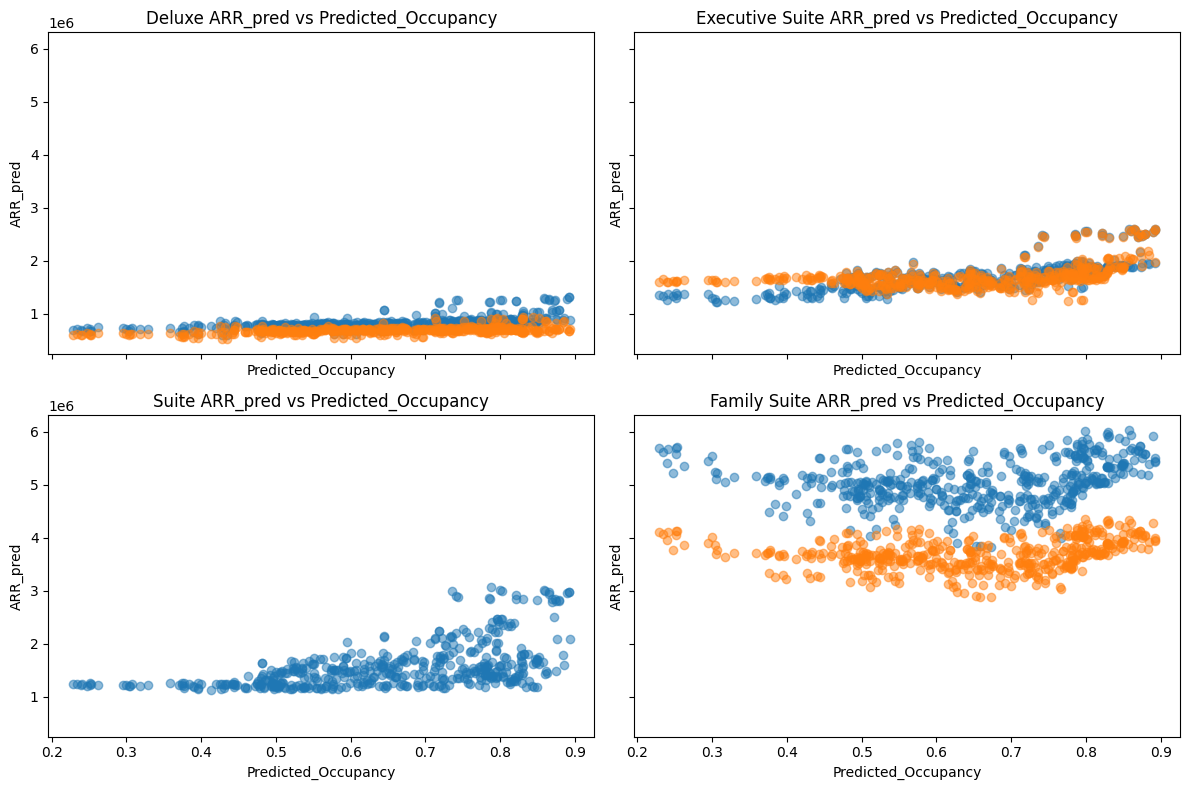

In [50]:
# visualize the ARR_rec per Room Type - Arrangement & Predicted_Occupancy
import matplotlib.pyplot as plt

# Create a figure for each room type
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot ARR_rec for each room type & arrangement
for i, rt in enumerate(['Deluxe', 'Executive Suite', 'Suite', 'Family Suite']):
    ax = axes[i]
    data = arrfuture[arrfuture['Room Type'] == rt]
    for arr in data['Arrangement'].unique():
        arr_data = data[data['Arrangement'] == arr]
        ax.scatter(arr_data['Occupancy Rate'], arr_data['ARR_pred'], alpha=0.5, label=arr)
    ax.set_title(f'{rt} ARR_pred vs Predicted_Occupancy')
    ax.set_xlabel('Predicted_Occupancy')
    ax.set_ylabel('ARR_pred')

plt.tight_layout()
plt.show()


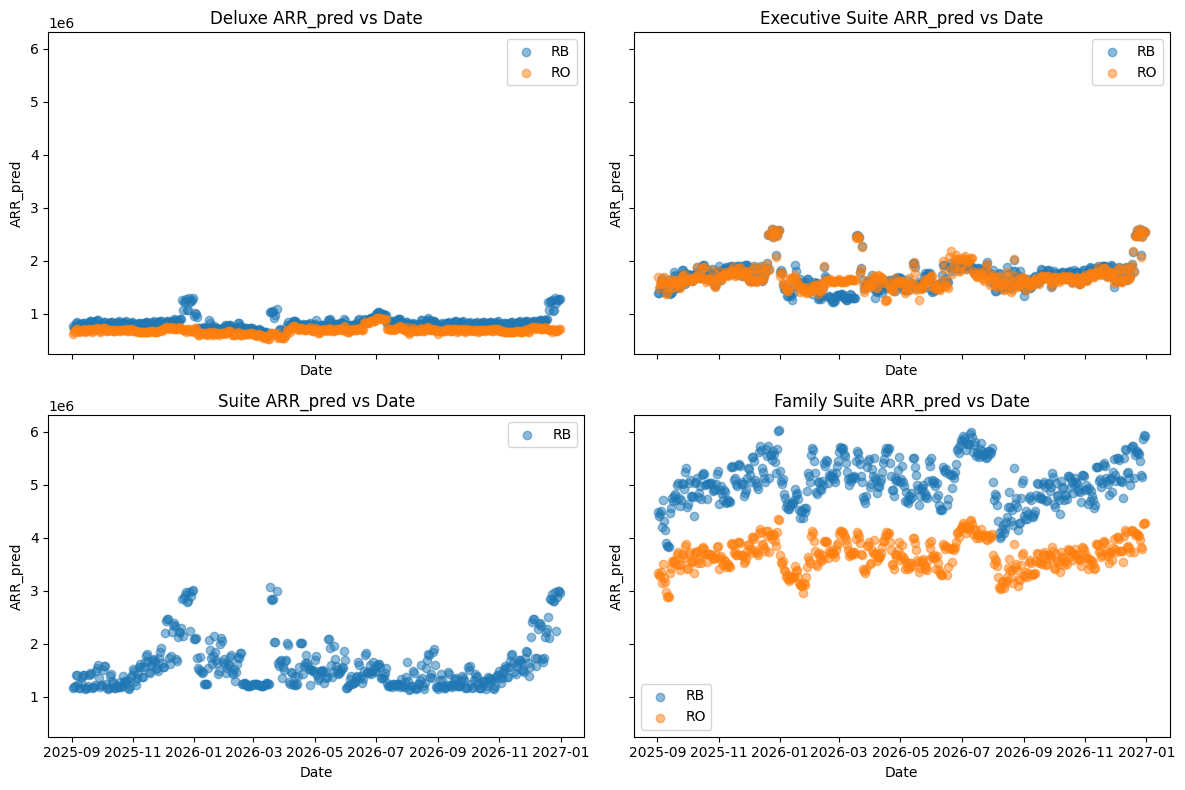

In [51]:
# visualize predicted ARR by date (filter by datestart from 2026-01-01), room type & arrangement

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot ARR_pred for each room type & arrangement
for i, rt in enumerate(['Deluxe', 'Executive Suite', 'Suite', 'Family Suite']):
    ax = axes[i]
    data = arrfuture[arrfuture['Room Type'] == rt]
    for arr in data['Arrangement'].unique():
        arr_data = data[data['Arrangement'] == arr]
        ax.scatter(arr_data['Date'], arr_data['ARR_pred'], alpha=0.5, label=arr)
    ax.set_title(f'{rt} ARR_pred vs Date')
    ax.set_xlabel('Date')
    ax.set_ylabel('ARR_pred')
    ax.legend()

plt.tight_layout()
plt.show()


In [52]:
# .describe ARR_pred per room type & arrangement
arrfuture.groupby(['Room Type', 'Arrangement'])['ARR_pred'].describe()


count          mean            std           min  \
Room Type       Arrangement                                                     
Deluxe          RB           486.0  8.345297e+05  114057.770741  5.993249e+05   
                RO           486.0  6.909074e+05   59819.500205  5.260389e+05   
Executive Suite RB           486.0  1.706236e+06  259686.295995  1.222619e+06   
                RO           486.0  1.704459e+06  235548.030400  1.241992e+06   
Family Suite    RB           486.0  5.053935e+06  416035.375328  3.830731e+06   
                RO           486.0  3.685102e+06  283813.801166  2.880933e+06   
Suite           RB           486.0  1.569369e+06  432356.958802  1.137800e+06   

                                      25%           50%           75%  \
Room Type       Arrangement                                             
Deluxe          RB           7.833203e+05  8.181131e+05  8.549267e+05   
                RO           6.636856e+05  6.911337e+05  7.140735e+05   
Executive Suite RB           1.538704e+06  1.686134e+06  1.825406e+06   
                RO           1.579680e+06  1.656560e+06  1.751828e+06   
Family Suite    RB           4.767881e+06  5.043643e+06  5.349423e+06   
                RO           3.503952e+06  3.683107e+06  3.885699e+06   
Suite           RB           1.249752e+06  1.450845e+06  1.686179e+06   

                                      max  
Room Type       Arrangement                
Deluxe          RB           1.309101e+06  
                RO           9.311567e+05  
Executive Suite RB           2.604094e+06  
                RO           2.602276e+06  
Family Suite    RB           6.031996e+06  
                RO           4.353738e+06  
Suite           RB           3.064032e+06

In [53]:
#arrfuture to csv

#arrfuture['Occupancy Rate'] = arrfuture['Occupancy Rate'].round(2)
#arrfuture['ARR_pred'] = arrfuture['ARR_pred'].round(2)
arrfuture.to_csv('arrfuture.csv', index=False)
arrfuture



,Date,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,Occupancy Rate,Room Type,Arrangement,ARR_pred
0,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RB,7.645343e+05
1,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Deluxe,RO,6.254294e+05
2,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Executive Suite,RB,1.389624e+06
3,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Suite,RB,1.160606e+06
4,2025-09-02,False,False,False,False,False,False,False,0,0,3,1,2,9,2025,0.376563,Family Suite,RB,4.483187e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RB,2.543900e+06
3398,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Suite,RB,2.954481e+06
3399,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Family Suite,RB,5.925039e+06
3400,2026-12-31,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,0.889191,Executive Suite,RO,2.545240e+06


# Combine

In [54]:
# make df combining historical data with predicted data
historis = arrtrain.copy()
future = arrfuture.copy()

historis['status'] = 'historical'
future = future.rename(columns={'ARR_pred': 'Average Room Rate'})
future['status'] = 'predicted'

combined_df = pd.concat([historis, future], ignore_index=True)

# format to number not float, rounding to 2 decimal places  
combined_df['Average Room Rate'] = combined_df['Average Room Rate'].astype(int)
# make occupancy rate to percentage with '%' (2 decimals)
#combined_df['Occupancy Rate'] = combined_df['Occupancy Rate']*100
combined_df['Occupancy Rate'] = combined_df['Occupancy Rate'].round(4)
#combined_df['Occupancy Rate'] = combined_df['Occupancy Rate'].astype(str) + '%'

# make date 2d
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Date'] = combined_df['Date'].dt.strftime('%Y-%m-%d')

combined_df.info()

# export to csv
combined_df.to_csv('combined_df.csv', index=False)

# save to csv
combined_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 5584 non-null   object 
 1   Arrangement          5583 non-null   object 
 2   Room Type            5584 non-null   object 
 3   Average Room Rate    5584 non-null   int64  
 4   Occupancy Rate       5584 non-null   float64
 5   Is_NationalHoliday   5584 non-null   bool   
 6   Is_Weekend           5584 non-null   bool   
 7   Is_Event             5584 non-null   bool   
 8   Is_SchoolHoliday     5584 non-null   bool   
 9   Is_Fasting           5584 non-null   bool   
 10  Is_Bridge            5584 non-null   bool   
 11  Is_Holiday           5584 non-null   bool   
 12  Holiday_Duration     5584 non-null   int64  
 13  Days_of_Holiday      5584 non-null   int64  
 14  Distance_to_Holiday  5584 non-null   int64  
 15  Day_of_Week          5584 non-null   i

,Date,Arrangement,Room Type,Average Room Rate,Occupancy Rate,Is_NationalHoliday,Is_Weekend,Is_Event,Is_SchoolHoliday,Is_Fasting,Is_Bridge,Is_Holiday,Holiday_Duration,Days_of_Holiday,Distance_to_Holiday,Day_of_Week,Day_of_Month,Month,Year,status
0,2024-01-01,NaN,Deluxe,500000,0.6333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024,historical
1,2024-01-01,RB,Deluxe,1035475,0.6333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024,historical
2,2024-01-01,RO,Deluxe,567218,0.6333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024,historical
3,2024-01-01,RB,Executive Suite,2136354,0.6333,True,False,False,False,False,False,True,1,1,0,0,1,1,2024,historical
4,2024-01-02,RB,Deluxe,833592,0.6222,False,False,False,False,False,False,False,0,0,1,1,2,1,2024,historical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,2026-12-31,RB,Executive Suite,2543900,0.8892,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,predicted
5580,2026-12-31,RB,Suite,2954481,0.8892,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,predicted
5581,2026-12-31,RB,Family Suite,5925038,0.8892,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,predicted
5582,2026-12-31,RO,Executive Suite,2545240,0.8892,False,False,False,True,False,False,False,0,0,4,3,31,12,2026,predicted
